# Hong-Ou-Mandel Effect with Perceval

The **Hong-Ou-Mandel (HOM) effect** describes the quantum interference of two indistinguishable photons meeting at a balanced (50:50) beam splitter.

**Setup:**
- 2-mode linear optical circuit
- 1 balanced beam splitter connecting the two modes
- Input state: one photon in each mode → |1,1⟩

**Expected result:**  
When two indistinguishable photons enter a balanced beam splitter (one per input mode), quantum interference causes them to always **bunch** — both photons exit together through the same output port. The |1,1⟩ output is **never** observed (probability = 0).

$$|1,1\rangle \xrightarrow{\text{BS}} \frac{1}{\sqrt{2}}\bigl(|2,0\rangle - |0,2\rangle\bigr)$$

## 1 — Imports

In [1]:
import perceval as pcvl
import perceval.components as comp
from perceval import pdisplay, PS, BS, Circuit, BasicState, Processor, StateVector
import numpy as np

## 2 — Build the circuit

A 2-mode circuit with a single balanced beam splitter (BS). In Perceval, `BS()` creates a 50:50 beam splitter by default.

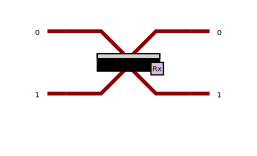

In [2]:
# Create a 2-mode circuit with one balanced beam splitter
circuit = Circuit(2) // BS()

# Display the circuit
pdisplay(circuit)

## 3 — Inspect the unitary matrix

The beam splitter's unitary matrix should be:

$$U_{BS} = \frac{1}{\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}$$

In [3]:
# Display the unitary matrix of the beam splitter
pdisplay(circuit.compute_unitary())

<IPython.core.display.Math object>

## 4 — Define the input state and simulate

Input state: **|1,1⟩** — one photon in each mode.

We use the `Analyzer` (or `Processor` with `SLOS` backend) to compute the output probability distribution.

In [4]:
# Define the input state: one photon per mode |1,1⟩
input_state = BasicState([1, 1])

# Set up a Processor with the SLOS (Strong Linear Optical Simulation) backend
processor = Processor("SLOS", circuit)

# Set the input state
processor.with_input(input_state)

# Run the simulation — get output probability distribution
output_distribution = processor.probs()["results"]

# Display the results
print("Input state: |1,1⟩\n")
print("Output probability distribution:")
for state, prob in output_distribution.items():
    print(f"  {state}: {prob:.4f}")

Input state: |1,1⟩

Output probability distribution:
  |2,0>: 0.5000
  |0,2>: 0.5000


## 5 — Analyze with the Analyzer

Use Perceval's `Analyzer` to get the full transition matrix between Fock states, confirming that the |1,1⟩ → |1,1⟩ amplitude is zero.

In [5]:
from perceval.algorithm import Analyzer

# Define the possible input and output Fock states with 2 photons across 2 modes
states = [
    BasicState([2, 0]),  # both photons in mode 0
    BasicState([1, 1]),  # one photon in each mode
    BasicState([0, 2]),  # both photons in mode 1
]

# Create the analyzer
analyzer = Analyzer(processor, states)

# Compute and display the full probability table
pdisplay(analyzer)

,"|2,0>","|1,1>","|0,2>"
"|2,0>",1/4,1/2,1/4
"|1,1>",1/2,0,1/2
"|0,2>",1/4,1/2,1/4


## 6 — Visualize: HOM dip

We can also simulate the HOM dip by varying the relative phase between the two input photons (equivalently, their distinguishability). A phase shifter on one arm lets us sweep from indistinguishable (φ=0) to distinguishable photons.

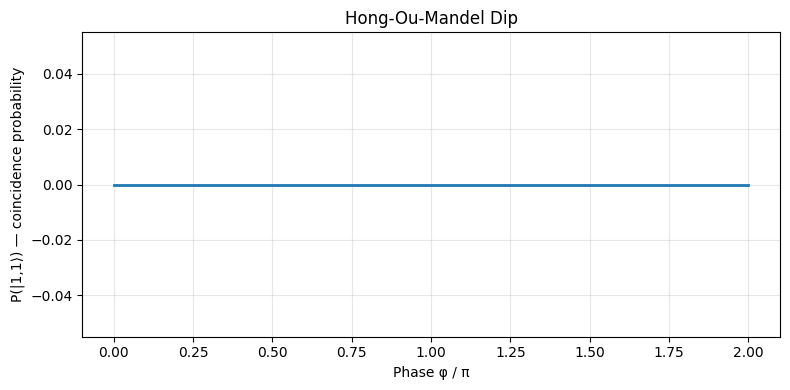

In [6]:
import matplotlib.pyplot as plt

# Sweep the phase from 0 to 2π on one arm before the beam splitter
phases = np.linspace(0, 2 * np.pi, 100)
coincidence_probs = []

for phi in phases:
    # Build circuit: phase shifter on mode 0, then beam splitter
    c = Circuit(2) // (0, PS(phi)) // BS()

    p = Processor("SLOS", c)
    p.with_input(BasicState([1, 1]))
    dist = p.probs()["results"]

    # Coincidence probability = probability of |1,1⟩ at output
    coincidence_probs.append(dist.get(BasicState([1, 1]), 0))

# Plot the HOM dip
plt.figure(figsize=(8, 4))
plt.plot(phases / np.pi, coincidence_probs, linewidth=2)
plt.xlabel("Phase φ / π")
plt.ylabel("P(|1,1⟩) — coincidence probability")
plt.title("Hong-Ou-Mandel Dip")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7 — State evolution (symbolic)

We can also look at the output state vector analytically using Perceval's `StateVector` tools.

In [7]:
# Compute the output state vector using the circuit's unitary
# For the basic BS circuit (no phase shifter)
backend = pcvl.BackendFactory.get_backend("SLOS")
backend.set_circuit(circuit)
backend.set_input_state(BasicState([1, 1]))

# Display the output state vector
print("Output state vector for |1,1⟩ through a balanced BS:")
print()
sv = backend.prob_amplitude(BasicState([2, 0]))
print(f"  Amplitude of |2,0⟩: {sv:.4f}  →  P = {abs(sv)**2:.4f}")

sv11 = backend.prob_amplitude(BasicState([1, 1]))
print(f"  Amplitude of |1,1⟩: {sv11:.4f}  →  P = {abs(sv11)**2:.4f}")

sv02 = backend.prob_amplitude(BasicState([0, 2]))
print(f"  Amplitude of |0,2⟩: {sv02:.4f}  →  P = {abs(sv02)**2:.4f}")

print()
print("✓ The |1,1⟩ output has probability 0 — this is the HOM effect!")
print("  Both photons always exit together through the same port.")

Output state vector for |1,1⟩ through a balanced BS:

  Amplitude of |2,0⟩: 0.0000+0.7071j  →  P = 0.5000
  Amplitude of |1,1⟩: 0.0000+0.0000j  →  P = 0.0000
  Amplitude of |0,2⟩: 0.0000+0.7071j  →  P = 0.5000

✓ The |1,1⟩ output has probability 0 — this is the HOM effect!
  Both photons always exit together through the same port.
